In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from config import gmap_api_key
import gmaps
from ipywidgets.embed import embed_minimal_html
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Read in relevant datasets
mental_df = pd.read_csv("Resources/mental.csv")

# By State Analysis

1. Which states report higher percentages of depression or anxiety symptoms? Blue or Red States?
2. Do states with more health professional shortage areas report higher percentages of depression or anxiety symptoms?
3. Does the state government makeup affect heatlh professional shortage areas?


In [3]:
#Separating Household Pulse Survey by indicator
# depression = mental_df.loc[(mental_df["Group"] == "By State")& \
#                              (mental_df["Indicator"] == "Symptoms of Depressive Disorder"),:]
# anxiety=mental_df.loc[(mental_df["Group"] == "By State") \
#                         &(mental_df["Indicator"] == "Symptoms of Anxiety Disorder"),:]
anxiety_depression = mental_df.loc[(mental_df["Group"] == "By State") \
                                     &(mental_df["Indicator"] == \
                                       "Symptoms of Anxiety Disorder or Depressive Disorder"),:]

In [4]:
anxiety_depression_states = pd.DataFrame({"State":anxiety_depression["State"].unique(),"Lat":"","Lng":""})
for index,row in anxiety_depression_states.iterrows():
    state = row["State"]
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={state}&key={gmap_api_key}"
    response = requests.get(target_url).json()
    try:
        lat = response['results'][0]['geometry']['location']['lat']
        lng = response['results'][0]['geometry']['location']['lng']
        anxiety_depression_states.loc[index,"Lat"]=lat
        anxiety_depression_states.loc[index,"Lng"]=lng
    except:
        print(f"{state} not found. Skipping...")
        pass
state_anxiety_depression = pd.merge(anxiety_depression,anxiety_depression_states, how="left",on="State")
state_anxiety_depression
time_periods = state_anxiety_depression["Time Period Label"].unique()
count = 0
for period in time_periods:
    period_filter = state_anxiety_depression.loc[state_anxiety_depression["Time Period Label"]==period,:]
    count = count + 1
    location = period_filter[["Lat","Lng"]]
    ratings = period_filter["Value"]
    gmaps.configure(api_key=gmap_api_key)
    fig = gmaps.figure()
    heat_layer = gmaps.heatmap_layer(location, weights=ratings, 
                                         dissipating=False,max_intensity=max(period_filter["Value"]),
                                         point_radius=1)
    fig.add_layer(heat_layer)
    fig
    embed_minimal_html(f'Anxiety OR Depression Heatmaps/{count}_{period}.html', views=[fig])

In [6]:
#Display most recent heatmap
recent = state_anxiety_depression.loc[state_anxiety_depression["Time Period Label"]=="Jun 29 - Jul 11, 2022",:]
coordinates = recent[["Lat","Lng"]]
recent_weights = recent["Value"]
gmaps.configure(api_key=gmap_api_key)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(coordinates, weights=recent_weights, 
                                         dissipating=False,max_intensity=max(recent["Value"]),
                                         point_radius=1)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

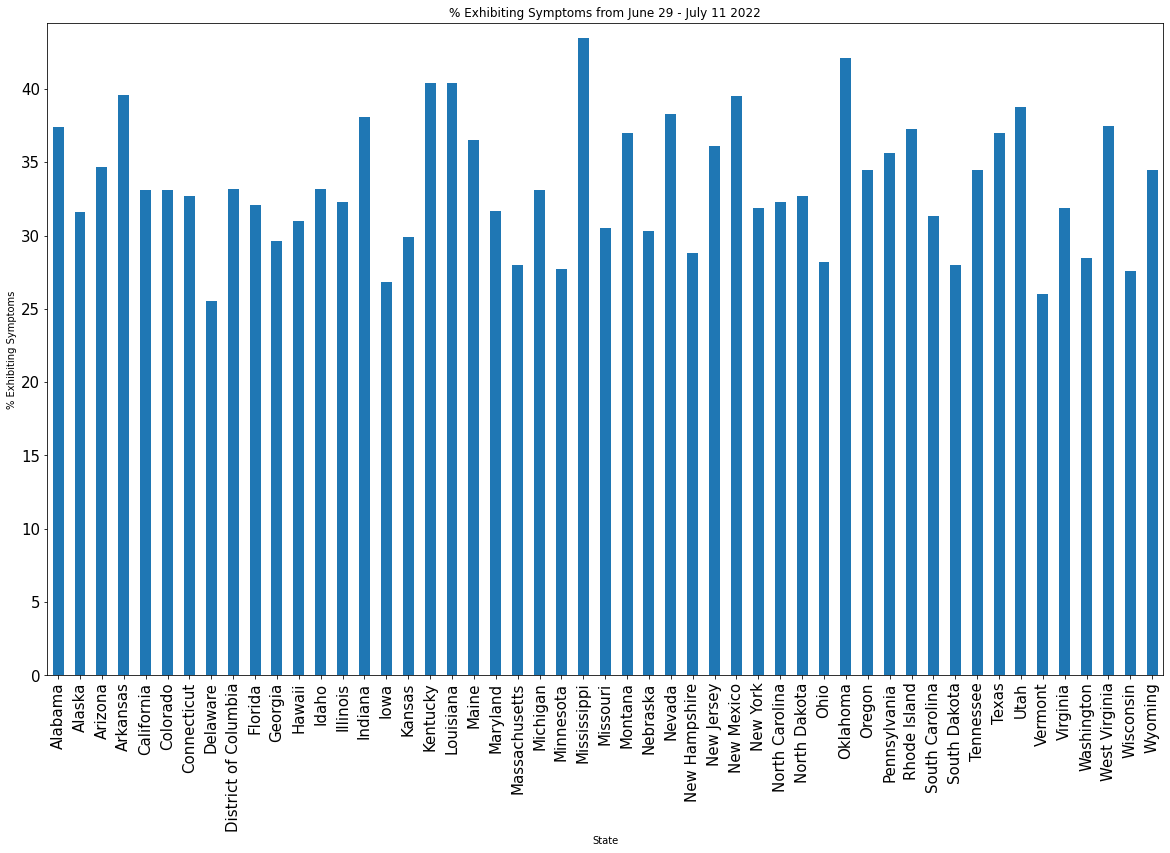

In [7]:
most_recent = state_anxiety_depression.loc[state_anxiety_depression["Time Period Label"] \
                             =="Jun 29 - Jul 11, 2022"]
most_recent.plot(kind="bar",x="State",y="Value",xlabel="State",ylabel="% Exhibiting Symptoms",figsize=(20,12),
                 ylim=(0,max(most_recent["Value"]+1)),legend=False,fontsize=15,title="% Exhibiting Symptoms from June 29 - July 11 2022")
plt.show()

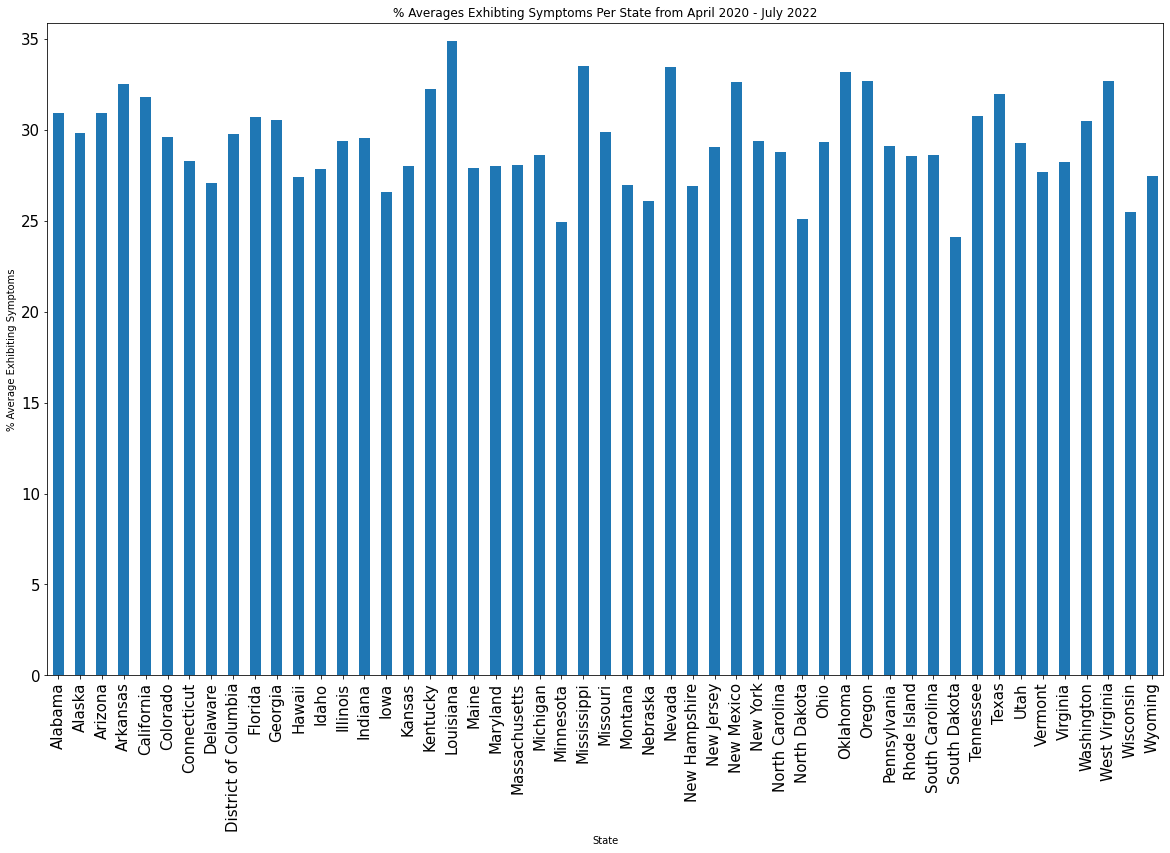

In [8]:
vote_count = pd.read_csv("Resources/2020_vote.csv")
group_state = pd.DataFrame(mental_df.groupby("State").mean()["Value"])
group_state = pd.merge(group_state,vote_count,on="State")

group_state.plot(kind="bar",x="State",y="Value",xlabel="State",ylabel="% Average Exhibiting Symptoms",
                 title = "% Averages Exhibting Symptoms Per State from April 2020 - July 2022",figsize=(20,12),
                 ylim=(0,max(group_state["Value"]+1)),legend=False,fontsize=15)
plt.show()

In [9]:
group_state.sort_values("Value",ascending=False).head(5)

,State,Value,called,Trifecta status
18,Louisiana,34.892199,R,Divided government
24,Mississippi,33.506383,R,Republican trifecta
28,Nevada,33.466667,D,Democratic trifecta
36,Oklahoma,33.199291,R,Republican trifecta
48,West Virginia,32.712766,R,Republican trifecta


In [10]:
group_state.sort_values("Value",ascending=False).tail(5)

,State,Value,called,Trifecta status
27,Nebraska,26.082270,R,Republican trifecta
49,Wisconsin,25.467376,D,Divided government
34,North Dakota,25.126241,R,Republican trifecta
23,Minnesota,24.943972,D,Divided government
41,South Dakota,24.134043,R,Republican trifecta


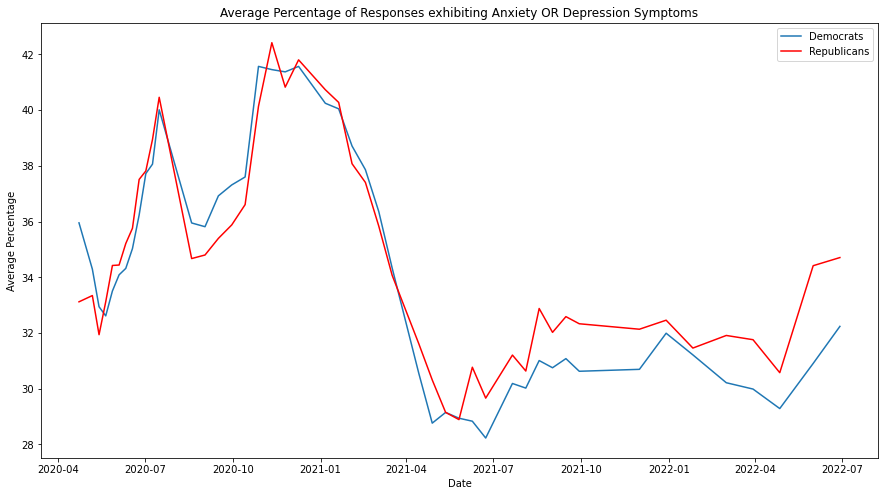

In [11]:
vote_mental = pd.merge(mental_df,vote_count,how="left",on="State")
vote_mental["Time Period Start Date"]=pd.to_datetime(vote_mental["Time Period Start Date"])
vote_mental["Time Period End Date"]=pd.to_datetime(vote_mental["Time Period End Date"])
vote_mental
anxiety_depression = vote_mental.loc[(vote_mental["Group"] == "By State") \
                                     &(vote_mental["Indicator"] == \
                                       "Symptoms of Anxiety Disorder or Depressive Disorder"),:]

plt.figure(figsize=(15,8))
democrats_mental = pd.DataFrame(anxiety_depression.loc[anxiety_depression["called"]=="D",:].groupby("Time Period Start Date").mean() \
["Value"]).reset_index(drop=False).sort_values("Time Period Start Date")
republicans_mental = anxiety_depression.loc[anxiety_depression["called"]=="R",:].groupby("Time Period Start Date").mean() \
["Value"].reset_index(drop=False).sort_values("Time Period Start Date")
plt.plot(democrats_mental["Time Period Start Date"],democrats_mental["Value"])
plt.plot(republicans_mental["Time Period Start Date"],republicans_mental["Value"],color="red")
# republicans_mental.plot(x="Time Period Start Date",y="Value")
# democrats_mental.plot(x="Time Period Start Date",y="Value")
plt.legend(["Democrats","Republicans"],loc="best")
plt.title("Average Percentage of Responses exhibiting Anxiety OR Depression Symptoms")
plt.ylabel("Average Percentage")
plt.xlabel("Date")
plt.show()

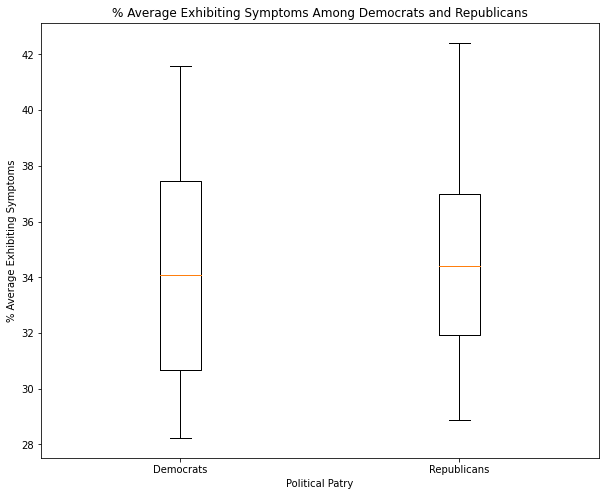

In [74]:
party_dict = {"Democrats":democrats_mental["Value"],"Republicans":republicans_mental["Value"]}
fig1,ax1=plt.subplots(figsize=(10,8))
ax1.boxplot(party_dict.values())
ax1.set_xlabel("Political Patry")
ax1.set_ylabel("% Average Exhibiting Symptoms")
ax1.set_title("% Average Exhibiting Symptoms Among Democrats and Republicans")
ax1.xaxis.set(ticklabels = ["Democrats","Republicans"])
plt.show()


In [12]:
providers_df = pd.read_csv("Resources/nmhss-puf-2020-csv.csv")
hpsa_df = pd.read_csv("Resources/HPSA.csv")
mh_providers = providers_df.loc[(providers_df["FOCUS"]==1),:]
mh_providers = mh_providers.rename(columns={'MHINTAKE':'Offers MH Intake', 'MHDIAGEVAL':'Offers MH Eval', 
                                                  'MHREFERRAL':'Offers MH Referal','TREATPSYCHOTHRPY':'Offers Psychotherapy',
                                            "TREATGRPTHRPY":'Offers Group Therapy','TREATCOGTHRPY':'Offers CBT',
                                            "TREATDIALTHRPY":'Offers DBT','TREATCOGREM':'Offers CR','NOTREAT':"No Treatment"})

In [13]:
#Providers DataFrame Clean-up
clean_providers = mh_providers.groupby("State").sum().reset_index()
#clean_providers = providers_df.groupby("State").sum()

summary_providers=clean_providers[['State','Offers MH Intake','Offers MH Eval','Offers MH Referal',
                                   'Offers Psychotherapy','Offers Group Therapy','Offers CBT','Offers DBT',
                                   'Offers CR','No Treatment']]
providers_merge = pd.merge(hpsa_df,summary_providers,how="left",on='State')


In [14]:
top_5 = most_recent.sort_values("Value",ascending=False)
top_5 = top_5.iloc[0:5,:]
top_5 = pd.merge(top_5,providers_merge,how="left",on="State")
top_5["% Need Met"]=round(top_5["Percent of Need Met"]*100,2)

#Markers for Percentages, Health Professional Shortage Areas
info_box_template = """
<dl>
<dt>% Exhibiting Symptoms</dt><dd>{Value}%</dd>
<dt># of HPSA</dt><dd>{Total Mental Health Care HPSA Designations}</dd>
<dt>% of Need Met</dt><dd>{% Need Met}%</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
marker_info = [info_box_template.format(**row) for index, row in top_5.iterrows()]
marker_locations = top_5[["Lat", "Lng"]]
markers = gmaps.marker_layer(marker_locations,info_box_content=marker_info)
fig.add_layer(markers)
# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
survey_providers_merge = pd.merge(recent,providers_merge,how="left",on="State")
survey_providers_merge["% Need Met"]=survey_providers_merge["Percent of Need Met"]*100
survey_providers_merge

#Binning
hpsa_bins=[0,50,150,300,600]
bin_labels=["<50","50-150","150-300","300-600"]
recent_summary = survey_providers_merge[['Indicator', 'Group', 'State','Time Period',
       'Time Period Label', 'Time Period Start Date', 'Time Period End Date',
       'Value', 'Total Mental Health Care HPSA Designations',
       'Population of Designated HPSAs', 'Percent of Need Met','% Need Met']]


recent_summary["HPSA Range"]=pd.cut(recent_summary["Total Mental Health Care HPSA Designations"],hpsa_bins,
                                    labels=bin_labels,include_lowest=True)
summary_mean=recent_summary.groupby("HPSA Range").mean()["Value"]
summary_max=recent_summary.groupby("HPSA Range").max()["Value"]
summary_min=recent_summary.groupby("HPSA Range").min()["Value"]
summary_median=recent_summary.groupby("HPSA Range").median()["Value"]
summary = pd.DataFrame({"Mean":summary_mean,"Max":summary_max,"Min":summary_min,"Median":summary_median})
summary

,Mean,Max,Min,Median
HPSA Range,,,,
<50,32.327273,38.8,25.5,32.70
50-150,34.028571,43.5,26.8,33.85
150-300,32.866667,40.4,28.5,32.30
300-600,33.900000,37.0,31.6,33.10


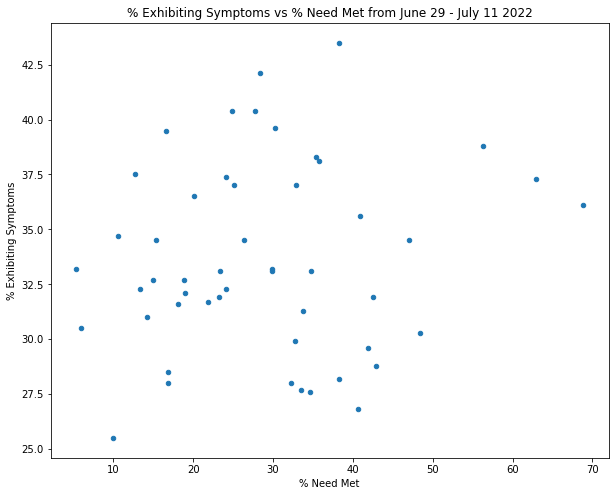

In [40]:
recent_summary.plot(kind="scatter",x='% Need Met',y="Value",ylabel="% Exhibiting Symptoms",
                    title="% Exhibiting Symptoms vs % Need Met from June 29 - July 11 2022",figsize=(10,8))
plt.show()

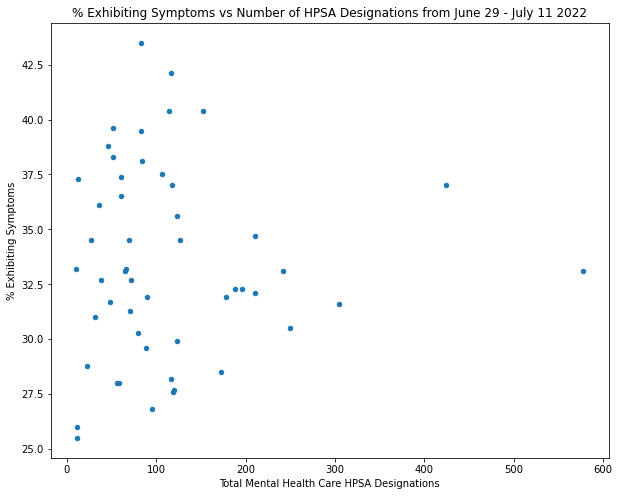

In [39]:
recent_summary.plot(kind="scatter",x='Total Mental Health Care HPSA Designations',y="Value",ylabel="% Exhibiting Symptoms",
                    title="% Exhibiting Symptoms vs Number of HPSA Designations from June 29 - July 11 2022",figsize=(10,8))
plt.show()

In [17]:
average_merge = pd.merge(group_state,providers_merge,on="State")
average_merge.sort_values("Percent of Need Met").head(10)

,State,Value,called,Trifecta status,Total Mental Health Care HPSA Designations,Population of Designated HPSAs,Percent of Need Met,Practitioners Needed to Remove HPSA Designation,Offers MH Intake,Offers MH Eval,Offers MH Referal,Offers Psychotherapy,Offers Group Therapy,Offers CBT,Offers DBT,Offers CR,No Treatment
8,District of Columbia,29.792908,D,Democratic trifecta,10,133945.0,0.0530,28.0,25.0,26.0,20.0,24.0,21.0,22.0,7.0,1.0,0.0
25,Missouri,29.920567,R,Republican trifecta,250,1836532.0,0.0593,140.0,123.0,128.0,124.0,123.0,118.0,122.0,70.0,1.0,1.0
7,Delaware,27.068794,D,Democratic trifecta,11,209638.0,0.0996,21.0,22.0,21.0,15.0,21.0,20.0,22.0,11.0,0.0,0.0
2,Arizona,30.965248,D,Republican trifecta,210,2884369.0,0.1061,184.0,116.0,114.0,106.0,139.0,134.0,141.0,67.0,5.0,4.0
48,West Virginia,32.712766,R,Republican trifecta,106,788500.0,0.1274,90.0,41.0,37.0,39.0,41.0,31.0,41.0,17.0,1.0,1.0
33,North Carolina,28.817021,R,Divided government,196,3586372.0,0.1336,199.0,117.0,89.0,83.0,112.0,107.0,118.0,36.0,3.0,1.0
11,Hawaii,27.439716,D,Democratic trifecta,31,496032.0,0.1422,28.0,23.0,27.0,26.0,24.0,19.0,22.0,10.0,0.0,0.0
6,Connecticut,28.277305,D,Democratic trifecta,38,1110816.0,0.1493,62.0,102.0,98.0,99.0,97.0,100.0,98.0,68.0,3.0,2.0
42,Tennessee,30.754610,R,Republican trifecta,69,3154955.0,0.1531,247.0,175.0,165.0,166.0,169.0,152.0,173.0,74.0,12.0,6.0
31,New Mexico,32.646809,D,Democratic trifecta,83,1363019.0,0.1664,74.0,30.0,30.0,32.0,31.0,26.0,28.0,12.0,1.0,1.0


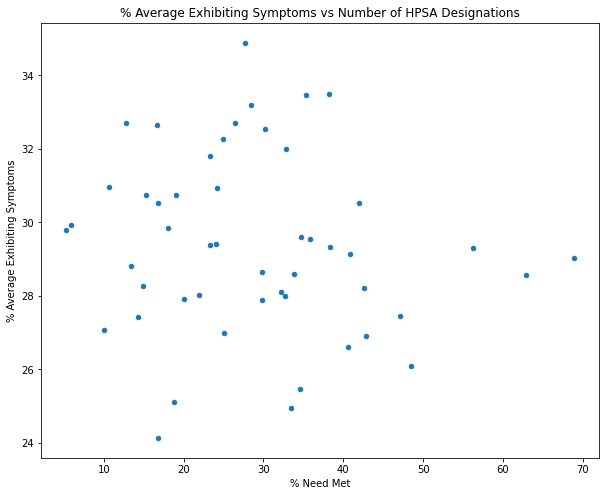

In [18]:
average_merge = pd.merge(group_state,providers_merge,on="State")
average_merge["% Need Met"]=average_merge["Percent of Need Met"]*100
average_merge.plot(kind="scatter",x="% Need Met",y="Value",
                   ylabel="% Average Exhibiting Symptoms",title="% Average Exhibiting Symptoms vs Number of HPSA Designations",figsize=(10,8))
plt.show()

In [26]:
st_govrn = pd.merge(anxiety_depression,providers_merge,how="left",on="State")
hpsa_st_gov_mean = st_govrn.groupby("Trifecta status").mean()["Total Mental Health Care HPSA Designations"]
hpsa_st_gov_max = st_govrn.groupby("Trifecta status").max()["Total Mental Health Care HPSA Designations"]
hpsa_st_gov_min = st_govrn.groupby("Trifecta status").min()["Total Mental Health Care HPSA Designations"]
percentneed_st_gov_mean = (st_govrn.groupby("Trifecta status").mean()["Percent of Need Met"])*100
percentneed__st_gov_max = (st_govrn.groupby("Trifecta status").max()["Percent of Need Met"])*100
percentneed__gov_min = (st_govrn.groupby("Trifecta status").min()["Percent of Need Met"])*100
hpsa_st_gov_count = st_govrn.groupby("Trifecta status").sum()["Total Mental Health Care HPSA Designations"]
value_st_gov_max =st_govrn.groupby("Trifecta status").max()["Value"]
value_st_gov_min=st_govrn.groupby("Trifecta status").min()["Value"]
value_st_gov_mean=st_govrn.groupby("Trifecta status").mean()["Value"]
summary_gov = pd.DataFrame({"HPSA Average":hpsa_st_gov_mean,
                           "HPSA Max":hpsa_st_gov_max,
                           "HPSA Min":hpsa_st_gov_min,
                           "HPSA Sum":hpsa_st_gov_count,
                            "% Need Met Average":percentneed_st_gov_mean,
                           "% Need Met Max":percentneed__st_gov_max,
                           "% Need Met Min":percentneed__gov_min})
#                            "% Max":value_st_gov_max,
#                            "% Min":value_st_gov_min,
#                            "% Mean":value_st_gov_mean})
summary_gov

,HPSA Average,HPSA Max,HPSA Min,HPSA Sum,% Need Met Average,% Need Met Max,% Need Met Min
Trifecta status,,,,,,,
Democratic trifecta,109.400000,578,10,77127,26.458000,68.85,5.30
Divided government,130.615385,304,11,79806,29.344167,42.55,13.36
Republican trifecta,109.695652,424,22,118581,30.131739,56.31,5.93


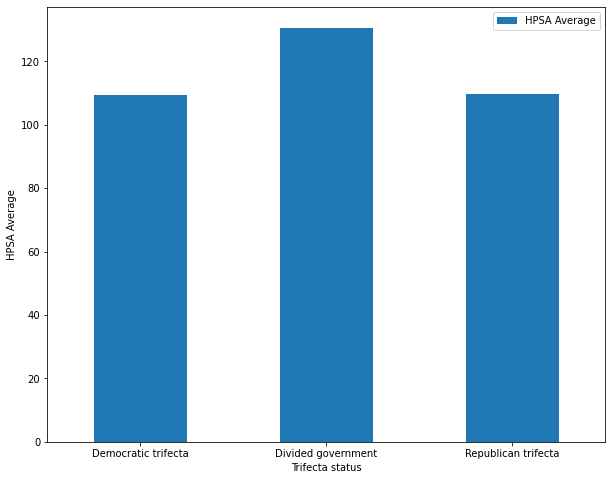

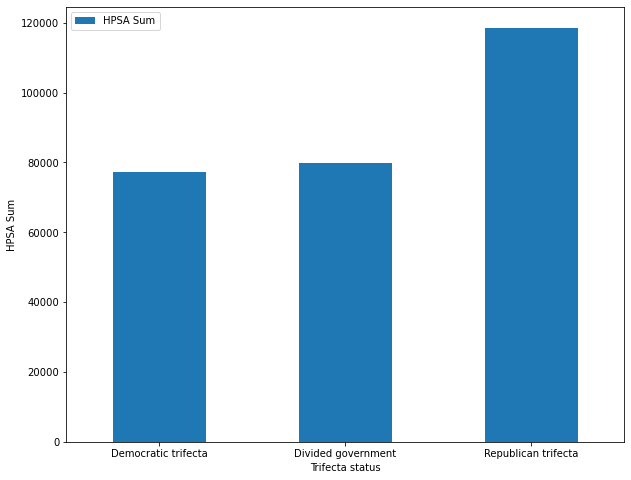

In [38]:
summary_gov.plot(kind="bar",y="HPSA Average",ylabel="HPSA Average",figsize=(10,8),rot=360)
summary_gov.plot(kind="bar",y="HPSA Sum",ylabel="HPSA Sum",figsize=(10,8),rot=360)
plt.show()

In [ ]:
# democrat_trifecta = st_govrn_providers.loc[(st_govrn_providers["Trifecta status"]=="Democratic trifecta") &
#                                            (st_govrn_providers["Time Period Label"]=="Jun 29 - Jul 11, 2022"),:]
# # democrat_trifecta = st_govrn_providers.loc[(st_govrn_providers["Trifecta status"]=="Democratic trifecta"),:]
# democrat_trifecta.plot(kind="bar",x="State",y=("Total Mental Health Care HPSA Designations"))
# democrat_trifecta.plot(kind="bar",x="State",y="Value")
# republican_trifecta = st_govrn_providers.loc[(st_govrn_providers["Trifecta status"]=="Republican trifecta") &
#                                            (st_govrn_providers["Time Period Label"]=="Jun 29 - Jul 11, 2022"),:]
# republican_trifecta.plot(kind="bar",x="State",y="Total Mental Health Care HPSA Designations",color="red")
# republican_trifecta.plot(kind="bar",x="State",y="Value",color="red")
# divided = st_govrn_providers.loc[(st_govrn_providers["Trifecta status"]=="Divided government") &
#                                            (st_govrn_providers["Time Period Label"]=="Jun 29 - Jul 11, 2022"),:]
# divided.plot(kind="bar",x="State",y=("Total Mental Health Care HPSA Designations"))
# divided.plot(kind="bar",x="State",y="Value")

In [41]:
#5 Lowest Percent of Need Met
lowest_need_met = pd.merge(providers_merge,vote_count,how="left",on="State")
lowest_need_met = lowest_need_met.sort_values("Percent of Need Met")
lowest_need_met=lowest_need_met.dropna()
lowest_need_met.head(5)

,State,Total Mental Health Care HPSA Designations,Population of Designated HPSAs,Percent of Need Met,Practitioners Needed to Remove HPSA Designation,Offers MH Intake,Offers MH Eval,Offers MH Referal,Offers Psychotherapy,Offers Group Therapy,Offers CBT,Offers DBT,Offers CR,No Treatment,called,Trifecta status
8,District of Columbia,10,133945.0,0.0530,28.0,25.0,26.0,20.0,24.0,21.0,22.0,7.0,1.0,0.0,D,Democratic trifecta
25,Missouri,250,1836532.0,0.0593,140.0,123.0,128.0,124.0,123.0,118.0,122.0,70.0,1.0,1.0,R,Republican trifecta
7,Delaware,11,209638.0,0.0996,21.0,22.0,21.0,15.0,21.0,20.0,22.0,11.0,0.0,0.0,D,Democratic trifecta
2,Arizona,210,2884369.0,0.1061,184.0,116.0,114.0,106.0,139.0,134.0,141.0,67.0,5.0,4.0,D,Republican trifecta
48,West Virginia,106,788500.0,0.1274,90.0,41.0,37.0,39.0,41.0,31.0,41.0,17.0,1.0,1.0,R,Republican trifecta


In [42]:
#5 Top Percent of Need Met
top_need_met = pd.merge(providers_merge,vote_count,how="left",on="State")
top_need_met = top_need_met.sort_values("Percent of Need Met",ascending=False)
top_need_met=top_need_met.dropna()
top_need_met.head(5)

,State,Total Mental Health Care HPSA Designations,Population of Designated HPSAs,Percent of Need Met,Practitioners Needed to Remove HPSA Designation,Offers MH Intake,Offers MH Eval,Offers MH Referal,Offers Psychotherapy,Offers Group Therapy,Offers CBT,Offers DBT,Offers CR,No Treatment,called,Trifecta status
30,New Jersey,36,40892.0,0.6885,14.0,206.0,213.0,190.0,194.0,198.0,192.0,105.0,7.0,3.0,D,Democratic trifecta
39,Rhode Island,12,395297.0,0.6291,10.0,15.0,18.0,20.0,20.0,20.0,21.0,17.0,1.0,0.0,D,Democratic trifecta
44,Utah,46,2803378.0,0.5631,73.0,140.0,145.0,134.0,144.0,132.0,137.0,118.0,17.0,2.0,R,Republican trifecta
27,Nebraska,80,1036048.0,0.4842,27.0,55.0,50.0,54.0,47.0,33.0,49.0,38.0,7.0,2.0,R,Republican trifecta
50,Wyoming,27,566581.0,0.4707,21.0,10.0,12.0,11.0,12.0,12.0,12.0,11.0,1.0,0.0,R,Republican trifecta


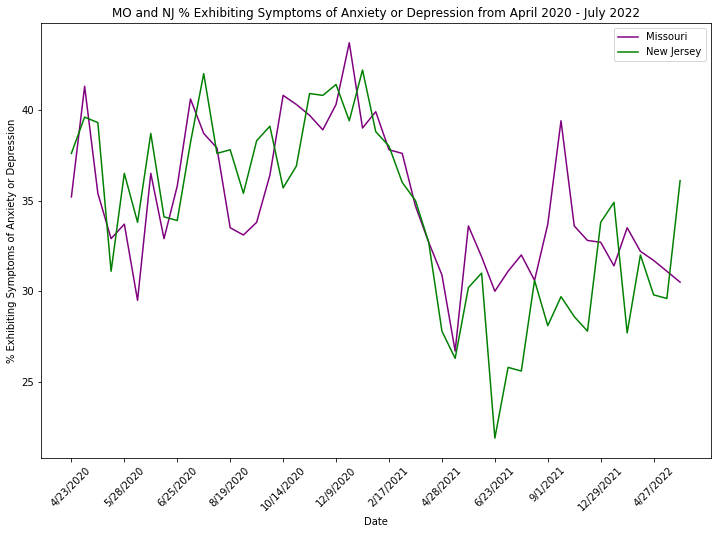

In [43]:
#Comparing Best and Worst
mo_df = state_anxiety_depression.loc[state_anxiety_depression["State"]=="Missouri",:]
nj_df = state_anxiety_depression.loc[state_anxiety_depression["State"]=="New Jersey",:]
plt.figure(figsize=(12,8))
plt.plot(mo_df["Time Period Start Date"],mo_df["Value"], color="purple")
plt.plot(nj_df["Time Period Start Date"],nj_df["Value"],color="green")
dates=mo_df["Time Period Start Date"]
ticks=dates[0:len(dates):4]
plt.title("MO and NJ % Exhibiting Symptoms of Anxiety or Depression from April 2020 - July 2022")
plt.xlabel("Date")
plt.ylabel("% Exhibiting Symptoms of Anxiety or Depression")
plt.legend(["Missouri","New Jersey"],loc="best")
plt.xticks(ticks,rotation=45)
plt.show()

# Conclusions

1. At a glance, Red states report higher percentages of anxiety or depression symptoms, nothing conclusive. It would be more approriate to say that depression and anxiety affect everyone regardless of political party.
2. A mental health survey with a question of political party would be better suited to tackle that analysis.
3. The amount of health professional shortage areas do not seem to have an effect on mental health. Scatter plots show no meaningful takeaways. This possibly gets into a public health discussion and how we as a society talk about mental health.
4. State government makeup may have a slight effect on health professional shortage areas. Divided state governments have more HPSA on average. States with a Republican trifecta have the greatest total sum of HPSAs.